In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/readme.txt
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/readme.txt.bak
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane27.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane45.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane71.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane83.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane61.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane10.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane69.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane14.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane47.tif
/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse

In [2]:
import os
import cv2
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
## Get paths and labels for all images in the directory.
def get_image_paths_and_labels(data_path):
    print("Step 1: Gathering image paths and labels...")
    image_paths = []
    labels = []
    categories = os.listdir(data_path)
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(category)
    print(f"Found {len(image_paths)} images across {len(categories)} categories.")
    return image_paths, labels, categories

In [4]:
# Extract Bag of SIFT features from each image, ensuring labels remain in sync.
def extract_bag_of_sifts(image_paths, labels, vocab_size=100):
    sift = cv2.SIFT_create()
    descriptors_list = []
    valid_image_paths = []
    valid_labels = []

    print("Step 2.1: Detecting and computing SIFT descriptors for images...")
    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image {img_path}. Skipping...")
            continue
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors_list.append(des)
            valid_image_paths.append(img_path)
            valid_labels.append(label)

    print("Step 2.2: Clustering SIFT descriptors to create visual vocabulary...")
    descriptors = np.vstack(descriptors_list)
    _, labels, centers = cv2.kmeans(
        descriptors.astype(np.float32),
        vocab_size,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )
    vocab = centers
    print(f"Visual vocabulary created with {vocab_size} clusters.")

    print("Step 2.3: Creating Bag-of-Words histograms for each image...")
    histograms = []
    for des in descriptors_list:
        histogram = np.zeros(vocab_size)
        for descriptor in des:
            distances = np.linalg.norm(vocab - descriptor, axis=1)
            cluster_id = np.argmin(distances)
            if cluster_id < vocab_size:
                histogram[cluster_id] += 1
        histograms.append(histogram)

    print("Bag-of-Words histograms created.")
    return np.array(histograms), valid_labels, vocab

In [5]:
def plot_confusion_matrix(cm, categories, output_path='confusion_matrix.png', title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plot the confusion matrix."""
    print("Step 5: Plotting confusion matrix...")
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, categories, rotation=45)
    plt.yticks(tick_marks, categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(output_path)
    print(f"Confusion matrix saved as {output_path}.")

In [6]:
image_paths, image_labels, categories = get_image_paths_and_labels('/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images')

Step 1: Gathering image paths and labels...
Found 2100 images across 21 categories.


In [7]:
vocab_size = 200
features, valid_labels, vocab = extract_bag_of_sifts(image_paths, image_labels, vocab_size)
features_train, features_test, labels_train, labels_test = train_test_split(features, valid_labels, test_size=0.3, random_state=42)

Step 2.1: Detecting and computing SIFT descriptors for images...
Step 2.2: Clustering SIFT descriptors to create visual vocabulary...
Visual vocabulary created with 200 clusters.
Step 2.3: Creating Bag-of-Words histograms for each image...
Bag-of-Words histograms created.


In [8]:
# Convert labels to numeric format
le = LabelEncoder()
labels_encoded = le.fit_transform(valid_labels)

In [9]:
# Split the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
                                                features, labels_encoded, test_size=0.2, random_state=42)

In [10]:
# Convert to PyTorch tensors
X_train_bow = torch.tensor(X_train_bow, dtype=torch.float32)
X_test_bow = torch.tensor(X_test_bow, dtype=torch.float32)
y_train_bow = torch.tensor(y_train_bow, dtype=torch.long)
y_test_bow = torch.tensor(y_test_bow, dtype=torch.long)

In [11]:
# Create DataLoaders
train_loader_bow = DataLoader(TensorDataset(X_train_bow, y_train_bow), batch_size=32, shuffle=True)
test_loader_bow = DataLoader(TensorDataset(X_test_bow, y_test_bow), batch_size=32, shuffle=False)

# Model with first and second layers both are ReLU Activation

In [12]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)    # First fully connected layer
        self.relu = nn.ReLU()                            # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size)   # Second fully connected layer
        self.fc3 = nn.Linear(hidden_size, num_classes)   # Output layer

    def forward(self, x):
        x = self.fc1(x)   # Pass input through first layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)   # Pass through second layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc3(x)   # Output layer (no activation)
        return x

In [13]:
# Initialize model
input_size = X_train_bow.shape[1]             # Number of BoS features
hidden_size = 128                             # Number of neurons in the hidden layer
num_classes = len(np.unique(labels_encoded))  # Number of unique classes
model = MLP(input_size, hidden_size, num_classes)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()                     # Cross entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [15]:
# Training loop for BoS features
num_epochs = 20                     # Number of epochs
for epoch in range(num_epochs):     # Iterate through each epoch
    model.train()                   # Set the model to training mode
    for batch in train_loader_bow:  # Iterate through batches of training data
        inputs, targets = batch     # Get the input features and target labels
        optimizer.zero_grad()       # Clear previous gradients
        outputs = model(inputs)     # Get predictions from the model
        loss = criterion(outputs, targets)  # Calculate loss (difference between predicted and true labels)
        loss.backward()             # Backpropagate the loss
        optimizer.step()            # Update model parameters using optimizer

    # Print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 1.7890
Epoch 2/20, Loss: 1.4273
Epoch 3/20, Loss: 1.6374
Epoch 4/20, Loss: 1.3987
Epoch 5/20, Loss: 0.3344
Epoch 6/20, Loss: 0.7023
Epoch 7/20, Loss: 0.4006
Epoch 8/20, Loss: 0.2447
Epoch 9/20, Loss: 0.5026
Epoch 10/20, Loss: 0.6035
Epoch 11/20, Loss: 0.2346
Epoch 12/20, Loss: 0.3236
Epoch 13/20, Loss: 0.1157
Epoch 14/20, Loss: 0.2067
Epoch 15/20, Loss: 0.3031
Epoch 16/20, Loss: 0.0381
Epoch 17/20, Loss: 0.0766
Epoch 18/20, Loss: 0.1020
Epoch 19/20, Loss: 0.0386
Epoch 20/20, Loss: 0.0113


In [16]:
# Evaluation for BoS features
model.eval()  # Set the model to evaluation mode
predictions, true_labels = [], []
with torch.no_grad():  # No need to compute gradients during evaluation
    for batch in test_loader_bow:  # Iterate through test data
        inputs, targets = batch
        outputs = model(inputs)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        predictions.extend(predicted.numpy())  # Add predicted labels
        true_labels.extend(targets.numpy())  # Add true labels

# Print classification report for BoW features
print("Classification Report for 3 Layer MLP with ReLU activation and 128 Nodes:")
print(classification_report(true_labels, predictions))

Classification Report for 3 Layer MLP with ReLU activation and 128 Nodes:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.78      0.67      0.72        21
           2       0.42      0.52      0.47        21
           3       0.85      0.81      0.83        21
           4       0.75      0.50      0.60        24
           5       0.94      0.94      0.94        16
           6       0.41      0.35      0.38        20
           7       0.81      0.81      0.81        16
           8       0.70      0.32      0.44        22
           9       0.71      0.60      0.65        20
          10       1.00      1.00      1.00        21
          11       0.75      0.41      0.53        22
          12       0.45      0.59      0.51        17
          13       0.67      0.71      0.69        14
          14       0.54      0.83      0.65        18
          15       1.00      0.96      0.98        26
       

In [17]:
# Generating Confusion Matrix
mlp_cm = confusion_matrix(true_labels, predictions)

Step 5: Plotting confusion matrix...
Confusion matrix saved as mlp_confusion_matrix_ReLU.png.


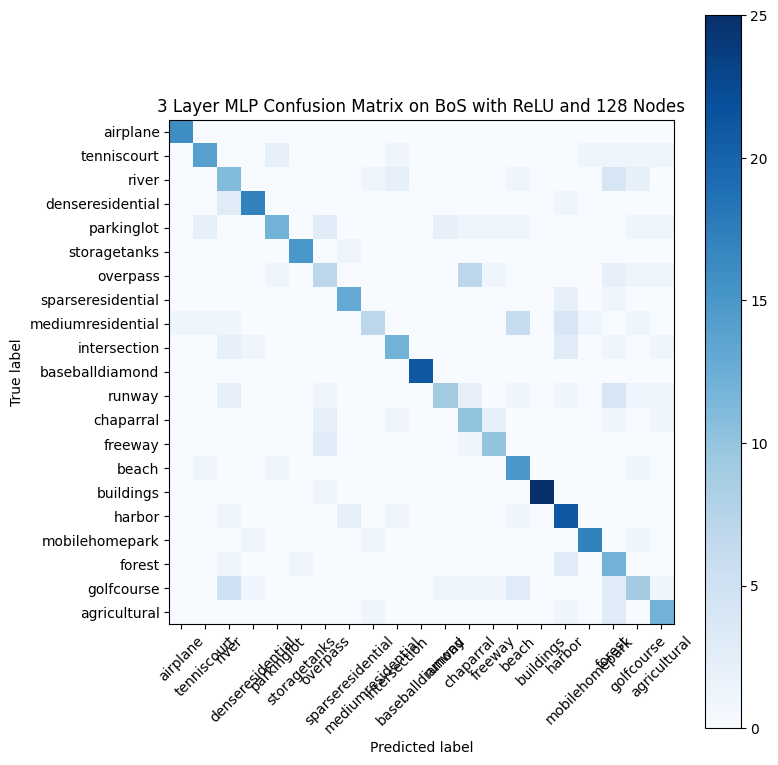

In [18]:
# Plotting Confusion Matrix
plot_confusion_matrix(mlp_cm, categories, output_path=f'mlp_confusion_matrix_ReLU.png', title=f'3 Layer MLP Confusion Matrix on BoS with ReLU and 128 Nodes')

# Model with first layer is ReLU and second layer is Sigmoid Activation

In [19]:
# Define MLP Model
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second fully connected layer
        self.sigmoid = nn.Sigmoid()                     # Sigmoid Activation function
        self.fc3 = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        x = self.fc1(x)  # Pass input through first layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Pass through second layer
        x = self.sigmoid(x)  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation)
        return x

In [20]:
# Initialize model
input_size = X_train_bow.shape[1]  # Number of BoW features
hidden_size = 256  # Number of neurons in the hidden layer
num_classes = len(np.unique(labels_encoded))  # Number of unique classes
model = MLP2(input_size, hidden_size, num_classes)

In [21]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [22]:
# Training loop for BoS features
num_epochs = 20                           # Number of epochs
for epoch in range(num_epochs):           # Iterate through each epoch
    model.train()                         # Set the model to training mode
    for batch in train_loader_bow:        # Iterate through batches of training data
        inputs, targets = batch           # Get the input features and target labels
        optimizer.zero_grad()             # Clear previous gradients
        outputs = model(inputs)           # Get predictions from the model
        loss = criterion(outputs, targets)  # Calculate loss (difference between predicted and true labels)
        loss.backward()                   # Backpropagate the loss
        optimizer.step()                  # Update model parameters using optimizer

    # Print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 1.6648
Epoch 2/20, Loss: 1.5545
Epoch 3/20, Loss: 1.2386
Epoch 4/20, Loss: 1.0606
Epoch 5/20, Loss: 0.4815
Epoch 6/20, Loss: 0.6526
Epoch 7/20, Loss: 0.6816
Epoch 8/20, Loss: 0.6695
Epoch 9/20, Loss: 0.2388
Epoch 10/20, Loss: 0.1450
Epoch 11/20, Loss: 0.2581
Epoch 12/20, Loss: 0.2963
Epoch 13/20, Loss: 0.1286
Epoch 14/20, Loss: 0.1524
Epoch 15/20, Loss: 0.1860
Epoch 16/20, Loss: 0.0992
Epoch 17/20, Loss: 0.0415
Epoch 18/20, Loss: 0.0199
Epoch 19/20, Loss: 0.0083
Epoch 20/20, Loss: 0.0915


In [23]:
# Evaluation for BoS features
model.eval()                             # Set the model to evaluation mode
predictions, true_labels = [], []
with torch.no_grad():                    # No need to compute gradients during evaluation
    for batch in test_loader_bow:        # Iterate through test data
        inputs, targets = batch
        outputs = model(inputs)          # Get predictions
        _, predicted = torch.max(outputs, 1)    # Get the class with the highest score
        predictions.extend(predicted.numpy())   # Add predicted labels
        true_labels.extend(targets.numpy())     # Add true labels

# Print classification report for BoW features
print("Classification Report for ReLU and Sigmoid Activation with 256 Nodes:")
print(classification_report(true_labels, predictions))

Classification Report for ReLU and Sigmoid Activation with 256 Nodes:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.83      0.71      0.77        21
           2       0.53      0.38      0.44        21
           3       0.72      0.86      0.78        21
           4       0.63      0.50      0.56        24
           5       0.94      1.00      0.97        16
           6       0.60      0.30      0.40        20
           7       0.82      0.88      0.85        16
           8       0.75      0.41      0.53        22
           9       0.70      0.70      0.70        20
          10       1.00      1.00      1.00        21
          11       0.56      0.68      0.61        22
          12       0.56      0.59      0.57        17
          13       0.59      0.93      0.72        14
          14       0.65      0.83      0.73        18
          15       0.96      0.96      0.96        26
          1

In [24]:
mlp2_cm = confusion_matrix(true_labels, predictions)

Step 5: Plotting confusion matrix...
Confusion matrix saved as mlp_confusion_matrix_ReLU&Sigmoid.png.


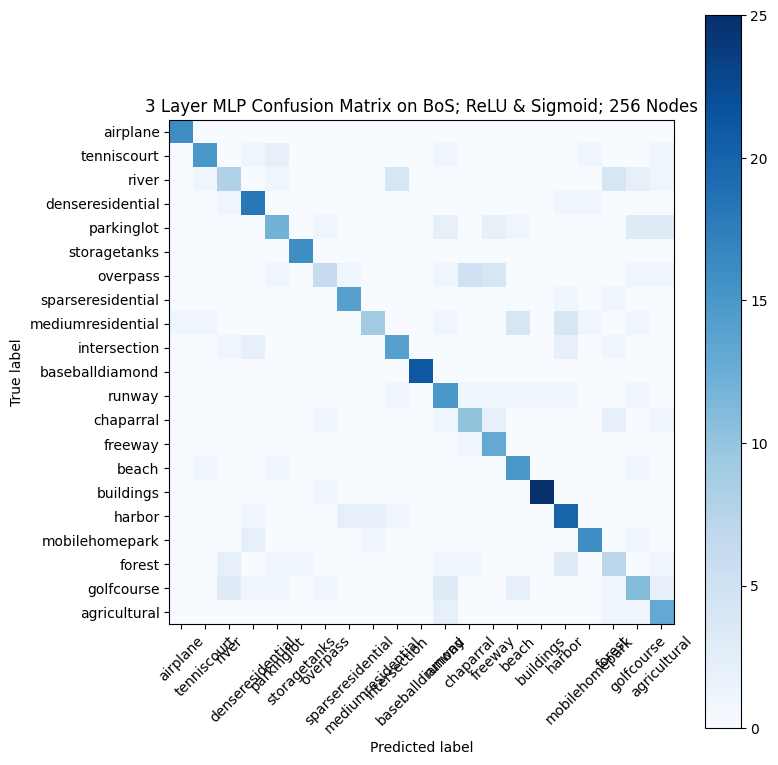

In [25]:
plot_confusion_matrix(mlp2_cm, categories, output_path=f'mlp_confusion_matrix_ReLU&Sigmoid.png', title=f'3 Layer MLP Confusion Matrix on BoS; ReLU & Sigmoid; 256 Nodes')

# Model on Resized Images with ReLU Activation

In [26]:
# Step 2: Load and Process Raw Images
print("Processing raw images...")
image_dir = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"  # Directory containing image data
image_paths, image_labels = [], []
for category in os.listdir(image_dir):  # Loop through each category (folder)
    category_path = os.path.join(image_dir, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):  # Loop through images in each category
            image_paths.append(os.path.join(category_path, img_name))  # Get image path
            image_labels.append(category)  # Get image category label


Processing raw images...


In [27]:
# vocab_size = 200
# features, valid_labels, vocab = extract_bag_of_sifts(image_paths, image_labels, vocab_size)
# # features_train, features_test, labels_train, labels_test = train_test_split(features, valid_labels, test_size=0.3, random_state=42)

In [28]:
# Convert image labels to numeric format
labels_encoded = le.fit_transform(image_labels)

# Resize images and flatten
image_data = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    img = cv2.resize(img, (72, 72)).flatten()  # Resize to 72x72 and flatten the image
    image_data.append(img)
image_data = np.array(image_data, dtype=np.float32) / 255.0  # Normalize pixel values to [0, 1]

In [29]:
# Split data into training and testing sets
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
                                    image_data, labels_encoded, test_size=0.2, random_state=42)

In [30]:
# Convert to PyTorch tensors
X_train_img = torch.tensor(X_train_img, dtype=torch.float32)
X_test_img = torch.tensor(X_test_img, dtype=torch.float32)
y_train_img = torch.tensor(y_train_img, dtype=torch.long)
y_test_img = torch.tensor(y_test_img, dtype=torch.long)

In [31]:
# Create DataLoaders for images
train_loader_img = DataLoader(TensorDataset(X_train_img, y_train_img), batch_size=32, shuffle=True)
test_loader_img = DataLoader(TensorDataset(X_test_img, y_test_img), batch_size=32, shuffle=False)

In [32]:
# Initialize model for raw images (same architecture as before)
input_size_img = X_train_img.shape[1]  # Number of flattened image pixels
model_img = MLP(input_size_img, hidden_size, num_classes)

In [33]:
# Loss and optimizer for image model
optimizer_img = optim.Adam(model_img.parameters(), lr=0.001)

In [34]:
# Training loop for raw images
for epoch in range(num_epochs):
    model_img.train()  # Set model to training mode
    for batch in train_loader_img:  # Iterate through image training batches
        inputs, targets = batch  # Get input features and target labels
        optimizer_img.zero_grad()  # Clear previous gradients
        outputs = model_img(inputs)  # Get predictions from the model
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagate the loss
        optimizer_img.step()  # Update model parameters

    # Print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 3.0212
Epoch 2/20, Loss: 3.0517
Epoch 3/20, Loss: 2.9814
Epoch 4/20, Loss: 3.0493
Epoch 5/20, Loss: 2.9380
Epoch 6/20, Loss: 2.7774
Epoch 7/20, Loss: 2.6817
Epoch 8/20, Loss: 2.7039
Epoch 9/20, Loss: 2.6596
Epoch 10/20, Loss: 3.3901
Epoch 11/20, Loss: 2.6755
Epoch 12/20, Loss: 3.1265
Epoch 13/20, Loss: 2.4152
Epoch 14/20, Loss: 2.6356
Epoch 15/20, Loss: 2.3967
Epoch 16/20, Loss: 2.2818
Epoch 17/20, Loss: 2.3292
Epoch 18/20, Loss: 2.7300
Epoch 19/20, Loss: 2.7654
Epoch 20/20, Loss: 2.6299


In [35]:
# Evaluation for raw images
model_img.eval()  # Set the model to evaluation mode
predictions_img, true_labels_img = [], []
with torch.no_grad():  # No gradients are needed during evaluation
    for batch in test_loader_img:  # Iterate through image test batches
        inputs, targets = batch
        outputs = model_img(inputs)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        predictions_img.extend(predicted.numpy())  # Add predicted labels
        true_labels_img.extend(targets.numpy())  # Add true labels

# Print classification report for raw images
print("Classification Report for Raw 72 * 72 Rescaled Images:")
print(classification_report(true_labels_img, predictions_img))

Classification Report for Raw 72 * 72 Rescaled Images:
              precision    recall  f1-score   support

           0       0.24      0.82      0.37        22
           1       0.18      0.10      0.12        21
           2       0.22      0.30      0.26        20
           3       0.30      0.91      0.45        23
           4       0.22      0.17      0.20        23
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        20
           7       0.36      0.86      0.51        14
           8       0.29      0.26      0.27        27
           9       0.17      0.06      0.08        18
          10       0.21      0.18      0.19        17
          11       0.00      0.00      0.00        16
          12       0.11      0.11      0.11        18
          13       0.10      0.15      0.12        20
          14       0.00      0.00      0.00        18
          15       0.23      0.12      0.16        24
          16       0.12   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
mlp_cm_img = confusion_matrix(true_labels_img, predictions_img)

Step 5: Plotting confusion matrix...
Confusion matrix saved as mlp_confusion_matrix72.png.


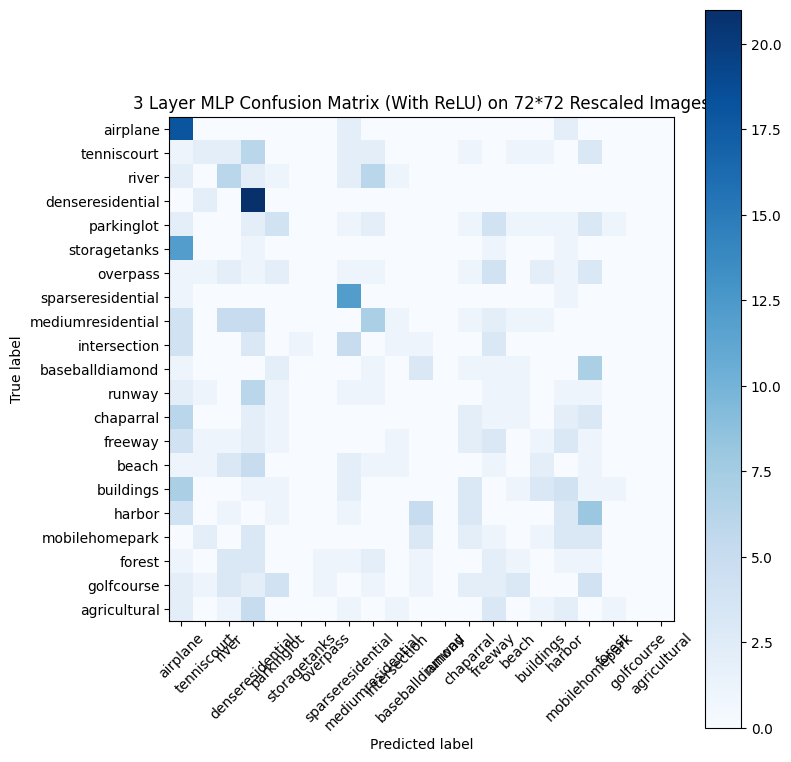

In [37]:
plot_confusion_matrix(mlp_cm_img, categories, output_path=f'mlp_confusion_matrix72.png', title=f'3 Layer MLP Confusion Matrix (With ReLU) on 72*72 Rescaled Images')

# MLP on Resized Images with 1st Layer as ReLU and 2nd Layer Sigmoid with 256 Nodes. 

In [38]:
# Initialize model for raw images (same architecture as before)
input_size_img = X_train_img.shape[1]  # Number of flattened image pixels
model_img2 = MLP2(input_size_img, hidden_size, num_classes)

In [39]:
# Loss and optimizer for image model
optimizer_img = optim.Adam(model_img2.parameters(), lr=0.001)

In [40]:
# Training loop for raw images
for epoch in range(num_epochs):
    model_img2.train()  # Set model to training mode
    for batch in train_loader_img:  # Iterate through image training batches
        inputs, targets = batch  # Get input features and target labels
        optimizer_img.zero_grad()  # Clear previous gradients
        outputs = model_img2(inputs)  # Get predictions from the model
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagate the loss
        optimizer_img.step()  # Update model parameters

    # Print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 2.9946
Epoch 2/20, Loss: 3.0693
Epoch 3/20, Loss: 3.0227
Epoch 4/20, Loss: 2.9190
Epoch 5/20, Loss: 3.0762
Epoch 6/20, Loss: 2.8852
Epoch 7/20, Loss: 2.7451
Epoch 8/20, Loss: 2.7897
Epoch 9/20, Loss: 2.6401
Epoch 10/20, Loss: 2.4517
Epoch 11/20, Loss: 2.6603
Epoch 12/20, Loss: 2.4668
Epoch 13/20, Loss: 2.5213
Epoch 14/20, Loss: 2.0072
Epoch 15/20, Loss: 2.6005
Epoch 16/20, Loss: 2.1662
Epoch 17/20, Loss: 2.0053
Epoch 18/20, Loss: 2.4720
Epoch 19/20, Loss: 2.1012
Epoch 20/20, Loss: 1.9974


In [41]:
# Evaluation for raw images
model_img2.eval()  # Set the model to evaluation mode
predictions_img, true_labels_img = [], []
with torch.no_grad():  # No gradients are needed during evaluation
    for batch in test_loader_img:  # Iterate through image test batches
        inputs, targets = batch
        outputs = model_img2(inputs)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        predictions_img.extend(predicted.numpy())  # Add predicted labels
        true_labels_img.extend(targets.numpy())  # Add true labels

# Print classification report for raw images
print("Classification Report for Raw 72 * 72 Rescaled Images with ReLU and Sigmoid:")
print(classification_report(true_labels_img, predictions_img))

Classification Report for Raw 72 * 72 Rescaled Images with ReLU and Sigmoid:
              precision    recall  f1-score   support

           0       0.18      0.14      0.15        22
           1       0.29      0.10      0.14        21
           2       0.36      0.20      0.26        20
           3       0.25      0.87      0.39        23
           4       0.26      0.26      0.26        23
           5       0.16      0.53      0.24        15
           6       0.13      0.10      0.11        20
           7       0.58      0.79      0.67        14
           8       0.36      0.48      0.41        27
           9       0.25      0.06      0.09        18
          10       0.60      0.35      0.44        17
          11       0.00      0.00      0.00        16
          12       0.20      0.11      0.14        18
          13       0.22      0.10      0.14        20
          14       0.07      0.22      0.11        18
          15       0.12      0.04      0.06        24
    

In [42]:
mlp_cm_img = confusion_matrix(true_labels_img, predictions_img)

Step 5: Plotting confusion matrix...
Confusion matrix saved as mlp_confusion_matrix72Sigmoid.png.


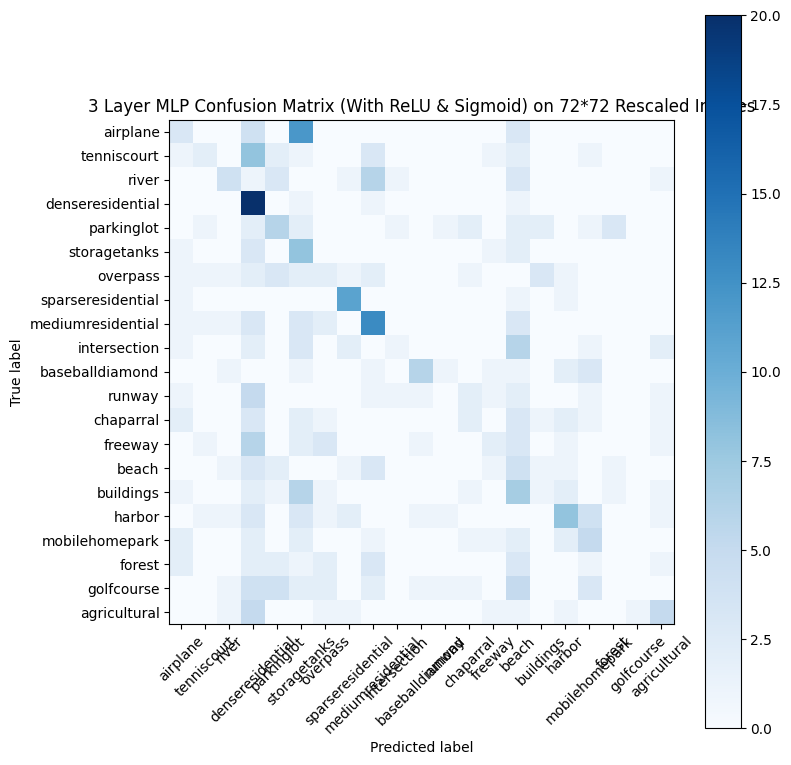

In [43]:
plot_confusion_matrix(mlp_cm_img, categories, output_path=f'mlp_confusion_matrix72Sigmoid.png', title=f'3 Layer MLP Confusion Matrix (With ReLU & Sigmoid) on 72*72 Rescaled Images')